# Figures for the heart

## Raster plot

In [1]:
import numpy as np 
import scipy as sp


import matplotlib.pyplot as plt



import os, sys
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)

import networkx as nx

from scipy.sparse import diags, coo_matrix
from scipy import sparse
import jax.numpy as jnp

import jax
from jax import lax, vmap, jit
import jax.random as random
from jax.experimental import sparse


In [2]:

def generate_laplacian(N, M, conduction_block_threshold, sparse_matrix=False, seed=0):
    num_nodes = N * M
    adj_rows = []
    adj_cols = []
    adj_data = []

    # Generate random conduction blocks
    np.random.seed(seed)
    conduction_blocks = np.random.rand(N, M) < conduction_block_threshold

    # Function to map grid (i, j) to a single node index
    def node_index(i, j):
        return i * M + j

    # Define neighbors for the nine-point stencil with weights
    neighbors = [
        (-1, 0, .5),     # up
        (1, 0, .5),      # down
        (0, -1, .5),     # left
        (0, 1, .5),      # right
        (-1, -1, .25),   # top-left
        (-1, 1, .25),    # top-right
        (1, -1, .25),    # bottom-left
        (1, 1, .25)      # bottom-right
    ]
    
    # Build adjacency structure excluding conduction blocks
    indices = np.array([[i, j] for i in range(N) for j in range(M)])
    idx = node_index(indices[:, 0], indices[:, 1])

    for di, dj, weight in neighbors:
        ni = indices[:, 0] + di
        nj = indices[:, 1] + dj

    # Step 1: Filter for in-bounds neighbors
        in_bounds = (ni >= 0) & (ni < N) & (nj >= 0) & (nj < M)
    
    # Step 2: Find valid indices (in-bounds) to avoid shape mismatches
        valid_indices = np.where(in_bounds)[0]
        ni_valid = ni[valid_indices]
        nj_valid = nj[valid_indices]

    # Step 3: Apply conduction block exclusion on the filtered indices
        valid_conduction = ~conduction_blocks[ni_valid, nj_valid]
        valid_node = ~conduction_blocks[indices[valid_indices, 0], indices[valid_indices, 1]]
        valid = valid_conduction & valid_node

    # Step 4: Append data for fully valid connections
        adj_rows.extend(idx[valid_indices][valid])
        adj_cols.extend(node_index(ni_valid[valid], nj_valid[valid]))
        adj_data.extend([weight] * int(np.sum(valid)))


    # Create adjacency and degree matrices
    adj_matrix = coo_matrix((adj_data, (adj_rows, adj_cols)), shape=(num_nodes, num_nodes))
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)

    # Construct Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix


    if sparse_matrix:

        return sparse.BCSR.from_scipy_sparse(laplacian_matrix), jnp.array(conduction_blocks)
    
    else:
        return laplacian_matrix.todense(), conduction_blocks



In [3]:
N_y=200
N_x=200
N=N_x*N_y
dts=500
L1, c1 = generate_laplacian(N_x,N_y,0, seed=1000, sparse_matrix=True)
L2,c2=generate_laplacian(N_x,N_y,0.35, seed=135, sparse_matrix=True)

In [4]:

def FHN_step(u, v, N, a, b, e, Du, sigma, L, key, delta_t):
    '''
    Perform a single step of the noisy FitzHugh-Nagumo model.
    Parameters:
    - u: state variable u
    - v: state variable v
    - N: number of nodes
    - a: parameter a
    - b: parameter b
    - e: parameter e giving the timescale separation between u and v
    - Du: Diffusion coefficient
    - sigma: noise intensity
    - L: Laplacian matrix
    - key: random key for noise generation
    - delta_t: time step
    Returns:
    - u_new: updated state variable u
    - v_new: updated state variable v
    '''
    # Generate Gaussian noise for each element of h
    noise = random.normal(key, u.shape)
    
    du = a * u * (u - b) * (1 - u) - Du * (L @ u) - v 
    dv = e * (u - v)
    u_new = u + du * delta_t + jnp.sqrt(delta_t * sigma**2) * noise
    v_new = v + dv * delta_t

    return u_new, v_new

def run_simulation(N, y0='wave', a=3, b=0.05, e=1e-2, Du=0.04, L=None, c1=None, sigma=0.0001, stimulus_time=1000, delta_t=0.1, total_time=3000.0, Nconf=3000, key=random.PRNGKey(2)):
    indices = jnp.where((jnp.arange(N) % 200 == 0) & (c1.flatten() == 0))[0]
    if y0 == 'wave':
        y0 = jnp.zeros(2 * N, dtype=jnp.float32)
        y0 = y0.at[indices].set(0.1)

    # Calculate the number of steps based on the total time and delta_t
    num_steps = int(total_time / delta_t)
    save_interval = num_steps // Nconf
    
    # Initialize state variables
    u = y0[:N]
    v = y0[N:]

    def scan_fn(carry, step):
        u, v, key, save_counter, u_saved, v_saved = carry
        key, subkey = random.split(key)
        
        # Apply stimulus to the specified indices
        u = jax.lax.cond((step > 0) & (step % int(stimulus_time / delta_t) == 0),
                          lambda u: u.at[indices].add(0.1),
                          lambda u: u,
                          u)

        u, v = FHN_step(u, v, N, a, b, e, Du, sigma, L, subkey, delta_t)
        
        # Save the configuration at the specified intervals
        save_counter = save_counter + 1
        u_saved = jax.lax.cond(save_counter % save_interval == 0,
                               lambda u_saved: u_saved.at[save_counter // save_interval - 1].set(u),
                               lambda u_saved: u_saved,
                               u_saved)
        v_saved = jax.lax.cond(save_counter % save_interval == 0,
                               lambda v_saved: v_saved.at[save_counter // save_interval - 1].set(v),
                               lambda v_saved: v_saved,
                               v_saved)
        
        return (u, v, key, save_counter, u_saved, v_saved), (u, v)

    # Preallocate arrays for saved configurations
    u_saved = jnp.zeros((Nconf, N), dtype=jnp.float32)
    v_saved = jnp.zeros((Nconf, N), dtype=jnp.float32)
    
    # Create a range of steps
    steps = jnp.arange(num_steps)
    
    # Run the scan function
    carry = (u, v, key, 0, u_saved, v_saved)
    carry, _ = lax.scan(scan_fn, carry, steps)

    u_saved = carry[4]
    v_saved = carry[5]

    return u_saved, v_saved

In [4]:
def threshold_matrix(matrix: jnp.ndarray, threshold: float) -> jnp.ndarray:
    """
    Scans a JAX matrix and returns a binary matrix where elements above 
    the threshold are 1 and elements below or equal to the threshold are 0.
    
    Parameters:
    matrix (jnp.ndarray): Input JAX matrix.
    threshold (float): Threshold value.
    
    Returns:
    jnp.ndarray: A binary matrix of the same shape as the input.
    """
    # Use jax.numpy.where to create a binary matrix
    return jnp.where(matrix > threshold, 1, 0)


In [64]:
u_sol, v_sol = run_simulation(N=N, sigma=0.0001,L=L1, c1=c1, key=random.PRNGKey(2),delta_t=0.1, total_time=7800, stimulus_time=1300, Nconf=400)
u_sol2, v_sol2 = run_simulation(N=N, sigma=0.0001,L=L2, c1=c2, key=random.PRNGKey(2),delta_t=0.1, total_time=7800, stimulus_time=1300, Nconf=400)
u_sol1=u_sol.T
u_sol2=u_sol2.T
binary1=threshold_matrix(u_sol1,0.08)
binary1=binary1.reshape(N_x,N_y,-1)
binary2=threshold_matrix(u_sol2,0.08)
binary2=binary2.reshape(N_x,N_y,-1)


In [65]:
u_sol2=u_sol2.reshape(200,200, -1)
u_sol1=u_sol1.reshape(200,200,-1)

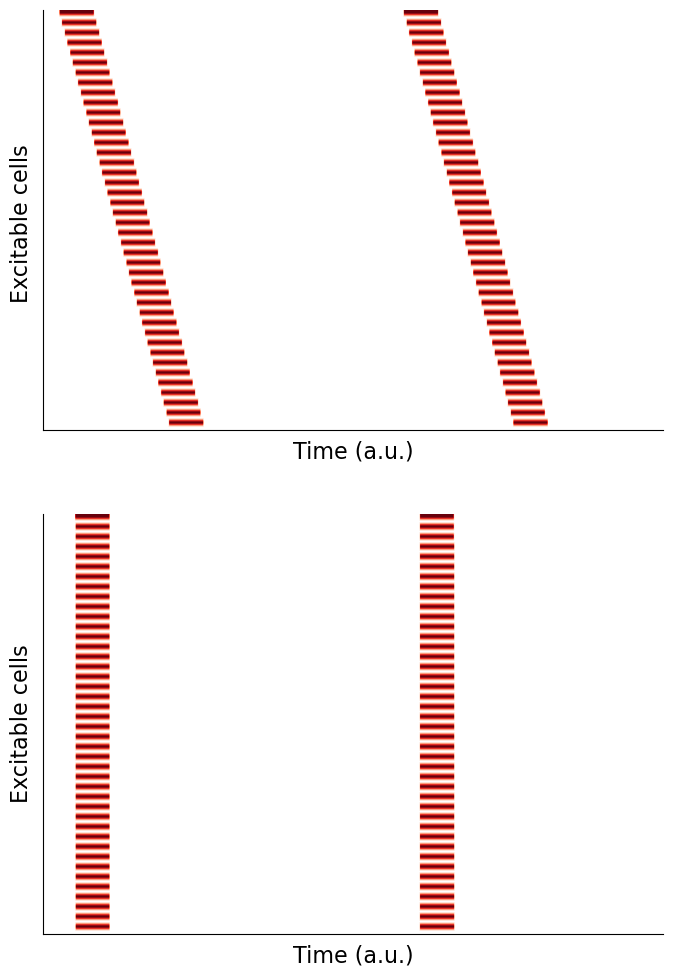

In [15]:
# Get the specific slices

data1 = binary1[20, 4:(N_y-4), :1500]

data2 = binary1[4:(N_y-4), 10, :1500]

# Add blank rows between binary rows for data1
N1, T1 = data1.shape
gap1 = 1  # Gap size (number of blank rows)
data1_with_blanks = np.zeros((N1 * (gap1 + 1), T1))
for i in range(N1):
    data1_with_blanks[i * (gap1 + 1), :] = data1[i, :]

# Add blank rows between binary rows for data2
N2, T2 = data2.shape
gap2 = 1  # Gap size (number of blank rows)
data2_with_blanks = np.zeros((N2 * (gap2 + 1), T2))
for i in range(N2):
    data2_with_blanks[i * (gap2 + 1), :] = data2[i, :]

# Create a custom colormap (transparent for 0, red for 1)
cmap = plt.cm.Reds
cmap = cmap(np.arange(cmap.N))
cmap[0, -1] = 0  # Set the alpha value of the first color (for 0) to 0 (fully transparent)
cmap = plt.matplotlib.colors.ListedColormap(cmap)


# Plot the data
plt.figure(figsize=(8, 12), facecolor='none')

# Plot data1
plt.subplot(2, 1, 1)
plt.imshow(data1_with_blanks, cmap=cmap, vmin=0, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.ylabel("Excitable cells ", fontsize=16)
plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)

# Plot data2
plt.subplot(2, 1, 2)
plt.imshow(data2_with_blanks, cmap=cmap, vmin=0, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.ylabel("Excitable cells", fontsize=16)
plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)

plt.show()

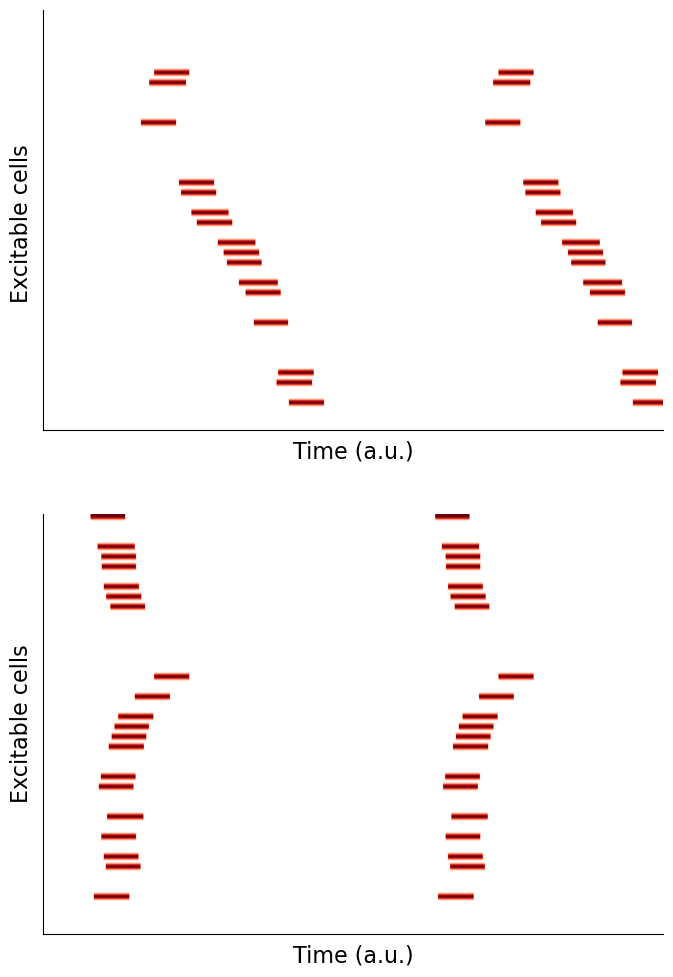

In [16]:
# Get the specific slices

data1 = binary2[20, 4:(N_y-4), :1500]

data2 = binary2[4:(N_y-4), 10, :1500]

# Add blank rows between binary rows for data1
N1, T1 = data1.shape
gap1 = 1  # Gap size (number of blank rows)
data1_with_blanks = np.zeros((N1 * (gap1 + 1), T1))
for i in range(N1):
    data1_with_blanks[i * (gap1 + 1), :] = data1[i, :]

# Add blank rows between binary rows for data2
N2, T2 = data2.shape
gap2 = 1  # Gap size (number of blank rows)
data2_with_blanks = np.zeros((N2 * (gap2 + 1), T2))
for i in range(N2):
    data2_with_blanks[i * (gap2 + 1), :] = data2[i, :]

# Create a custom colormap (transparent for 0, red for 1)
cmap = plt.cm.Reds
cmap = cmap(np.arange(cmap.N))
cmap[0, -1] = 0  # Set the alpha value of the first color (for 0) to 0 (fully transparent)
cmap = plt.matplotlib.colors.ListedColormap(cmap)


# Plot the data
plt.figure(figsize=(8, 12), facecolor='none')

# Plot data1
plt.subplot(2, 1, 1)
plt.imshow(data1_with_blanks, cmap=cmap, vmin=0, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.ylabel("Excitable cells ", fontsize=16)
plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)

# Plot data2
plt.subplot(2, 1, 2)
plt.imshow(data2_with_blanks, cmap=cmap, vmin=0, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.ylabel("Excitable cells", fontsize=16)
plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)

plt.show()

([], [])

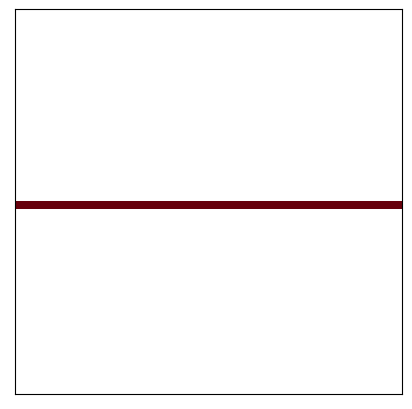

In [21]:

box1 = np.zeros((50, 50))
box1[25, :] = 1  # Set the 26th row to ones

# Create the second box with a column of ones
box2 = np.zeros((50, 50))
box2[:, 25] = 1  # Set the 26th column to ones
# Plot the data
plt.figure(figsize=(5, 5), facecolor='none')

# Plot box1

plt.imshow(box1, cmap=cmap, vmin=0, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks






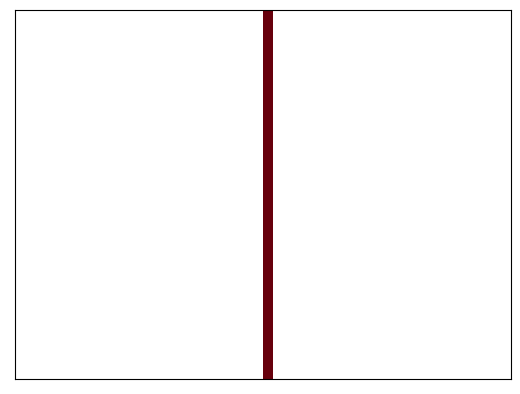

In [ ]:
# Plot box2
plt.figure(figsize=(5, 5), facecolor='none')
plt.imshow(box2, cmap=cmap, vmin=0, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks

plt.show()

# Comparison between phase extraction methods

In [111]:
L2,c2=generate_laplacian(N_x,N_y,0.45, seed=145, sparse_matrix=True)
u_sol2, v_sol2 = run_simulation(N=N, sigma=0.0001,L=L2, c1=c2, key=random.PRNGKey(2),delta_t=0.1, total_time=6500, stimulus_time=1300, Nconf=6500)
#u_sol1=u_sol.T
u_sol2=u_sol2.T


In [70]:

#1D implementation
def find_transitions(binary_array):
    """
    Find all the indices in T where the value for each n in N goes from 0 to 1.

    Parameters:
    ----------
    binary_array : jnp.ndarray
        2D array of binary values (N oscillators, T time steps).

    Returns:
    -------
    transitions : list of jnp.ndarray
        List of arrays, each containing the indices in T where the value goes from 0 to 1 for each n in N.
    """
    N, T = binary_array.shape
    transitions = []

    for i in range(N):
        # Find indices where the value goes from 0 to 1
        transition_indices = jnp.where(jnp.diff(binary_array[i, :], prepend=0) == 1)[0]
        transitions.append(transition_indices)

    return transitions

In [71]:
from scipy.signal import hilbert

# Function to compute the phase of each element across time using the Hilbert transform

def compute_phases(data):
    """
    Compute the phase of each element using the Hilbert transform.
    
    Parameters:
        data (np.ndarray): An (N, T) array where N is the number of elements and T is the time dimension.
        
    Returns:
        np.ndarray: An (N, T) array containing the phases.
    """
    # Apply Hilbert transform along the time axis
    analytic_signal = hilbert(data, axis=1)
    # Extract the phase of the analytic signal
    phases = np.angle(analytic_signal)
    return phases


def kuramoto_order_parameter(phases):
    """
    Compute the Kuramoto order parameter for the given phases.
    
    Parameters:
        phases (jnp.ndarray): An (N, T) array of phases for N elements over T time points.
        
    Returns:
        tuple:
            - jnp.ndarray: A (T,) array representing the amplitude of the Kuramoto order parameter over time.
            - jnp.ndarray: A (T,) array representing the phase of the Kuramoto order parameter over time.
    """
    N = phases.shape[0]
    
    order_parameter_complex = jnp.sum(jnp.exp(1j * phases), axis=0) / N
    
    amplitude = jnp.abs(order_parameter_complex)
   
    phase = jnp.angle(order_parameter_complex)
    return amplitude, phase

In [72]:


def interpolate_phases(transitions, T):
    """
    Interpolates the times between each two subsequent indices with values between 0 and 2π to define a phase.

    Parameters:
    ----------
    transitions : list of jnp.ndarray
        List of arrays, each containing the indices in T where the value goes from 0 to 1 for each n in N.
    T : int
        Total number of time steps.

    Returns:
    -------
    phase : jnp.ndarray
        2D array of phase for each oscillator at each time point (N oscillators, T time steps).
    """
    N = len(transitions)
    phase = jnp.zeros((N, T), dtype=float)

    for i in range(N):
        trans = transitions[i]
        for j in range(len(trans) - 1):
            start = trans[j]
            end = trans[j + 1]
            length = end - start
            segment_phase = jnp.linspace(0, 2 * jnp.pi, length, endpoint=False)
            phase = phase.at[i, start:end].set(segment_phase)
        # Set phase to 0 after the last transition
        if len(trans) > 0:
            phase = phase.at[i, trans[-1]:].set(0)

    return phase

In [76]:
##pure python implementation

def interpolate_phases(transitions, T):
    """
    Interpolates the times between each two subsequent indices with values between 0 and 2π to define a phase.

    Parameters:
    ----------
    transitions : list of np.ndarray
        List of arrays, each containing the indices in T where the value goes from 0 to 1 for each n in N.
    T : int
        Total number of time steps.

    Returns:
    -------
    phase : np.ndarray
        2D array of phase for each oscillator at each time point (N oscillators, T time steps).
    """
    N = len(transitions)
    phase = np.zeros((N, T), dtype=float)

    for i in range(N):
        trans = transitions[i]
        for j in range(len(trans) - 1):
            start = int(trans[j])
            end = int(trans[j + 1])
            length = end - start
            segment_phase = np.linspace(0, 2 * np.pi, length, endpoint=False)
            phase[i, start:end] = segment_phase
        # Set phase to 0 after the last transition
        if len(trans) > 0:
            phase[i, int(trans[-1]):] = 0.0

    return phase


In [114]:
u_sol=u_sol2.reshape(N_x,N_y,6500)
#u_sol2=u_sol2.reshape(N_x,N_y,-1)
c1=c1.reshape(N_x,N_y)
cnot=~c1[4:(N_x-4), 150]
cnot=cnot.flatten()
usol_phase=u_sol[4:(N_x-4),150,:]
phases_h=compute_phases(usol_phase[cnot, :])
#usol_phase=usol_phase.reshape(192*200,-1)

#print(usol_phase[:, :].shape)

binary_u = jnp.where(usol_phase > 0.08, 1, 0)
transitions=find_transitions(binary_u[cnot,:])
phase_s=interpolate_phases(transitions, usol_phase.shape[1])


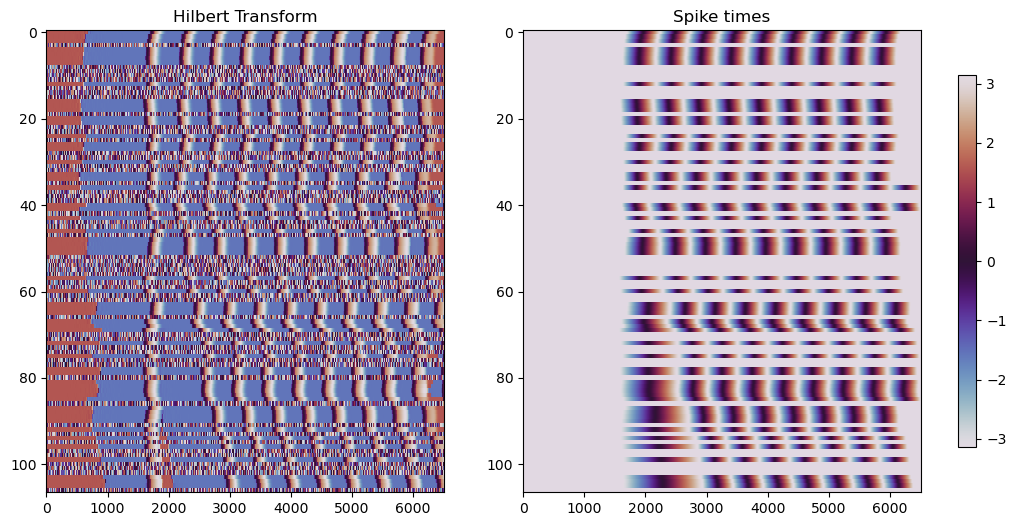

In [115]:

# Plot the phases for the specified frames
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot phases_h
im1 = axs[0].imshow(phases_h, cmap='twilight', interpolation='none',aspect='auto')
axs[0].set_title("Hilbert Transform")
#axs[0].set_xticks([])
#axs[0].set_yticks([])

# Plot phases_s
im2 = axs[1].imshow(phase_s, cmap='twilight',interpolation='none', aspect='auto')
axs[1].set_title("Spike times")
#axs[1].set_xticks([])
#axs[1].set_yticks([])

# Add a single colorbar for both plots
fig.colorbar(im1, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

#plt.tight_layout()
plt.show()

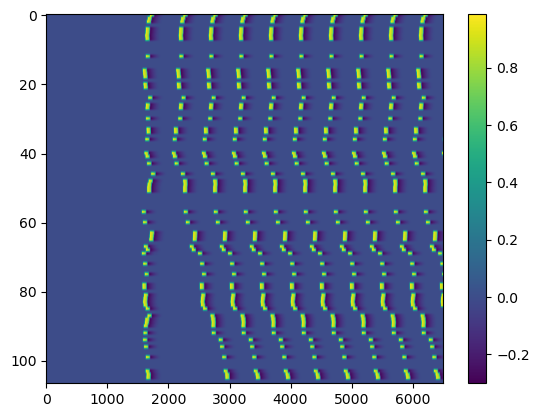

In [117]:
u=u_sol[4:(N_x-4),150,:]
plt.imshow(u[cnot, :], aspect='auto')
plt.colorbar()

# trials for patterns

In [5]:


def extract_center_submatrix(matrix, N1):
    """
    Extract the center submatrix of size (N1, N1, T) from an (N, N, T) matrix.
    
    Parameters:
        matrix (jax.numpy.ndarray): The input 3D matrix of shape (N, N, T).
        N1 (int): The size of the desired center submatrix.
        
    Returns:
        jax.numpy.ndarray: The extracted center submatrix of shape (N1, N1, T).
    """
    N, _, T = matrix.shape
    
    # Ensure N1 is not larger than N
    if N1 > N:
        raise ValueError("N1 cannot be larger than the input matrix dimensions.")

    # Compute start and end indices for slicing
    start_idx = (N - N1) // 2
    end_idx = start_idx + N1
    
    return matrix[start_idx:end_idx, start_idx:end_idx, :]


In [12]:
N_x=200
N_y=200
N=N_x*N_y
L2,c2=generate_laplacian(N_x,N_y,0.5, seed=145, sparse_matrix=True)
u_sol2, v_sol2 = run_simulation(N=N, sigma=0.0001,L=L2, c1=c2, key=random.PRNGKey(2),delta_t=0.1, total_time=6500, stimulus_time=1300, Nconf=6500)
#u_sol1=u_sol.T
u_sol2=u_sol2.T


In [6]:
#normalisation wrt to counts

def calculate_entropy_jax(binary_arrays):
    """
    Calculate the entropy of the patterns contained in a set of binary arrays.
    parameters:
    binary_arrays (jax.numpy.ndarray): A 2D array of binary arrays (N, T).
    Returns:
    tuple: A tuple containing:
        - float: The entropy of the binary arrays.
        - float: The normalized entropy of the binary arrays.
        - int: The length of each binary array.
    """
    # Calculate the number of unique patterns and their counts
    unique_patterns, counts = jnp.unique(binary_arrays, axis=1, return_counts=True)
    total_patterns = jnp.sum(counts)
    
    # Calculate probabilities
    probabilities = counts / total_patterns
    
    
    # Compute entropy using JAX
    entropy = -jnp.sum(probabilities * jnp.log2(probabilities))
    
    # Normalize entropy
    N = binary_arrays.shape[0]  # Length of each binary array
    max_entropy = N  # Maximum entropy for binary arrays of length N
    normalized_entropy = entropy / max_entropy
    return entropy, normalized_entropy, N 

In [7]:
# normalisation wrt to total number of possible patterns

def calculate_entropy_jax(binary_arrays, s):
    """
    Calculate the entropy of the patterns contained in a set of binary arrays.
    Parameters:
        binary_arrays (jax.numpy.ndarray): A 2D array of binary arrays (N, T).
        s (int): The length of each binary array.
    Returns:
        tuple: A tuple containing:
            - float: The entropy of the binary arrays.
            - float: The normalized entropy of the binary arrays.
            - int: The length of each binary array.
    """
    # Calculate the number of unique patterns and their counts
    unique_patterns, counts = jnp.unique(binary_arrays, axis=1, return_counts=True)
    total_patterns = jnp.sum(counts)
    
    # Compute probabilities in log space
    log_probabilities = jnp.log(counts) - s * jnp.log(2)
    
    # Convert log probabilities to entropy
    entropy = -jnp.sum(jnp.exp(log_probabilities) * log_probabilities / jnp.log(2))
    
    # Normalize entropy
    N = binary_arrays.shape[0]  # Length of each binary array
    max_entropy = N  # Maximum entropy for binary arrays of length N
    normalized_entropy = entropy / max_entropy

    return entropy, normalized_entropy, N


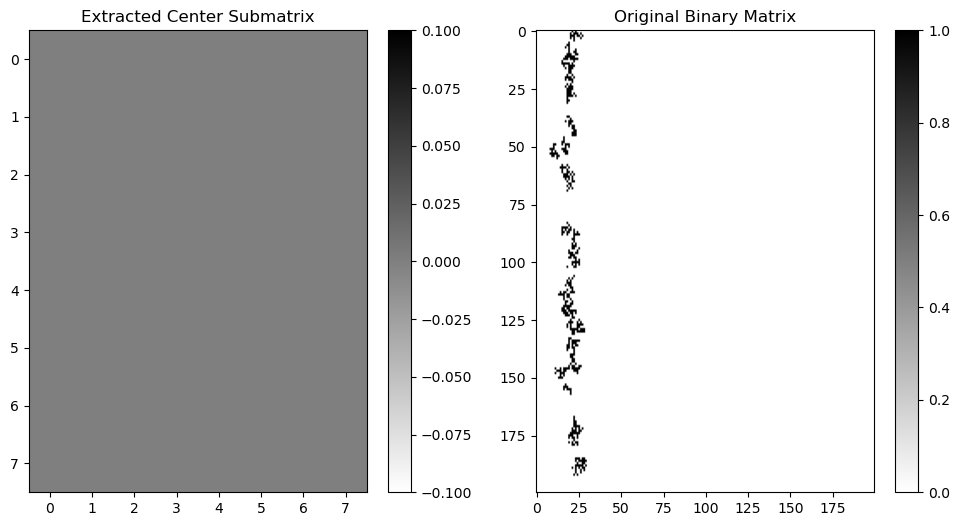

In [22]:
threshold = 0.08
binary_u = jnp.where(u_sol2 > threshold, 1, 0)
binary_u=binary_u.reshape(N_x,N_x,-1)
binary_u_e = extract_center_submatrix(binary_u, 8)
#binary_u = binary_u.reshape(100**2, -1)

plt.figure(figsize=(12, 6))

# Plot binary_u_e
plt.subplot(1, 2, 1)
plt.imshow(binary_u_e[:, :, 300], cmap='binary', aspect='auto')
plt.title("Extracted Center Submatrix")
plt.colorbar()

# Plot binary_u
plt.subplot(1, 2, 2)
plt.imshow(binary_u[:, :, 300], cmap='binary', aspect='auto')
plt.title("Original Binary Matrix")
plt.colorbar()

plt.show()



In [25]:
binary_u_e = binary_u_e.reshape(8**2, -1)
binary_u_e=binary_u_e[:,2600:]
print(binary_u_e.shape)





(64, 3900)


In [26]:
entropy, normalised, N=calculate_entropy_jax(binary_u_e, 100)
print(entropy, normalised, N)

2.84023e-25 4.4378595e-27 64


In [ ]:
##print(binary_u)
unique_patterns, counts = jnp.unique(binary_u_e, axis=1, return_counts=True)
print(unique_patterns, counts)
#3.838531 0.03838531 for arrhythmia
#0.84778225 0.008477823 for normal

In [28]:
def entropycalc(array, s):
    threshold = 0.08
    binary_u = jnp.where(array > threshold, 1, 0)
    binary_u=binary_u.reshape(N_x,N_x,-1)
    binary_u_e = extract_center_submatrix(binary_u, s)
    binary_u_e = binary_u_e.reshape(s**2, -1)
    binary_u_e=binary_u_e[:,2600:]
    entropy, normalised, N=calculate_entropy_jax(binary_u_e,s*s)
    return entropy, normalised

In [29]:
ent=[]
norma=[]
dts=1300
tdts=6500
N=200*200
N_x=200
# Loop over conduction threshold values
for i, conduction_threshold in enumerate(jnp.arange(0, 0.8, 0.01)):
    seed = int(conduction_threshold * 1000)
    L1, c1 = generate_laplacian(N_x, N_x, conduction_block_threshold=conduction_threshold, sparse_matrix=True, seed=seed)   
    print("{}/{}, m={}".format(i+1,len(jnp.arange(0,0.8,0.01)), conduction_threshold))
    u_sol, v_sol = run_simulation(N=N, sigma=0.0001,L=L1, c1=c1, key=random.PRNGKey(seed),delta_t=0.1, total_time=6500, stimulus_time=1300, Nconf=6500)
    u_sol=u_sol.T
    entropy, norm=entropycalc(u_sol, 8)

    
    ent.append(entropy)
    norma.append(norm)    

1/80, m=0.0
2/80, m=0.009999999776482582
3/80, m=0.019999999552965164
4/80, m=0.029999999329447746
5/80, m=0.03999999910593033
6/80, m=0.04999999701976776
7/80, m=0.05999999865889549
8/80, m=0.07000000029802322
9/80, m=0.07999999821186066
10/80, m=0.08999999612569809
11/80, m=0.09999999403953552
12/80, m=0.10999999940395355
13/80, m=0.11999999731779099
14/80, m=0.12999999523162842
15/80, m=0.14000000059604645
16/80, m=0.14999999105930328
17/80, m=0.1599999964237213
18/80, m=0.17000000178813934
19/80, m=0.17999999225139618
20/80, m=0.1899999976158142
21/80, m=0.19999998807907104
22/80, m=0.20999999344348907
23/80, m=0.2199999988079071
24/80, m=0.22999998927116394
25/80, m=0.23999999463558197
26/80, m=0.25
27/80, m=0.25999999046325684
28/80, m=0.26999998092651367
29/80, m=0.2800000011920929
30/80, m=0.28999999165534973
31/80, m=0.29999998211860657
32/80, m=0.3100000023841858
33/80, m=0.3199999928474426
34/80, m=0.32999998331069946
35/80, m=0.3400000035762787
36/80, m=0.3499999940395355
3

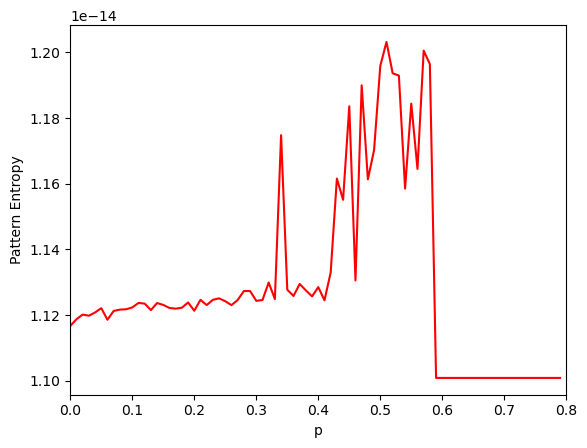

<Figure size 640x480 with 0 Axes>

In [30]:
ent = jnp.array(ent)
plt.plot(jnp.arange(0, 0.8, 0.01), ent,c='r')
plt.xlabel('p')
plt.ylabel('Pattern Entropy')
plt.xlim(0, 0.8)

#plt.legend()
#plt.title('Kuramoto order parameter vs. conduction threshold')
plt.savefig('entropy_norm_by2_20_s=20_400_frames_noise.png')
plt.show()
